In [2]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)
library(preprocessCore)
library(circlize)
`%ni%` <- Negate(`%in%`)

In [3]:
get_CPM_values <- function(input, meta, cell_annot_alot){
  
  meta_data <- read.delim(meta) %>% 
        rename(cell_type = !!sym(cell_annot_alot)) 
    
    
  raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)
    
  merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    group_by(cell_type, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

  ### Alt CPM Calc
  merged_meta_cpm_information_copied <- merged_meta_cpm_information
  catch <- merged_meta_cpm_information_copied  %>%
    group_by(cell_type) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()

  caught_values <- as_tibble(catch)
  #see <- ungroup(merged_meta_cpm_information_copied)
  merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, caught_values)  %>% 
    rename(grouped_CPM = value)
    
    
  quantile_normalized_values <- merged_meta_cpm_information_copied %>% 
        group_by(cell_type) %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

    
    
  quantile_normalized <- as_tibble(quantile_normalized_values)  %>% 
        dplyr::rename("quant_norm_cpm" = value)


  quantile_normalized_data <- bind_cols(merged_meta_cpm_information_copied, quantile_normalized) %>% 
        group_by(geneID)
        #dplyr::mutate(Zscore = scale(quant_norm_cpm))



  return(quantile_normalized_data)
}



In [4]:
generate_matrix_for_heatmap <- function(cell_type_by_gene_by_quant_norm, markers) {
    
    
    mat <- cell_type_by_gene_by_quant_norm %>%
        dplyr::filter(cell_type %in% c("mesophyll", "bundle_sheath")) %>% 
        dplyr::filter(geneID %in% markers$geneID) %>% 
        left_join(., markers, by = c("geneID")) %>% 
        dplyr::ungroup() %>%   
        dplyr::select(cell_type, name, quant_norm_cpm) %>% 
        pivot_wider(names_from = cell_type, values_from = quant_norm_cpm) %>% 
        dplyr::rowwise() %>% 
        dplyr::mutate(log2_val = log2(bundle_sheath/mesophyll)) %>% 
        dplyr::select(name, log2_val) 
}

In [5]:
output_location <- "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_2/heatmaps/"

In [6]:
zm_input_data <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/zea_mays/acc_metrics_zea_may.v4_annot/zea_mays.gene_body_acc_zea_may.v4_annot.counts.txt"
zm_meta <- "/scratch/jpm73279/comparative_single_cell/07.call.ACRs/replicate_analysis_one_off/zm/Zm.leaf_annot.V5.meta.frozen.txt"
zm_marker_file <-"/home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/markers/C4_markers.txt"
zm_markers <- read_delim(zm_marker_file, delim = "\t", col_names = c("chrom", "start", "stop", "geneID", "name", "type"))

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 27 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (6): chrom, geneID, name, type, X7, X8
dbl (2): start, stop

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
zm_cpm_values <- get_CPM_values(zm_input_data, zm_meta, "final_annotation")

zm_C4_matrix <- generate_matrix_for_heatmap(zm_cpm_values, zm_markers)

zm_df <- data.frame(zm_C4_matrix, row.names = 1)

Rows: 22253352 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


Warning message:
"The input is a data frame-like object, convert it to a matrix."


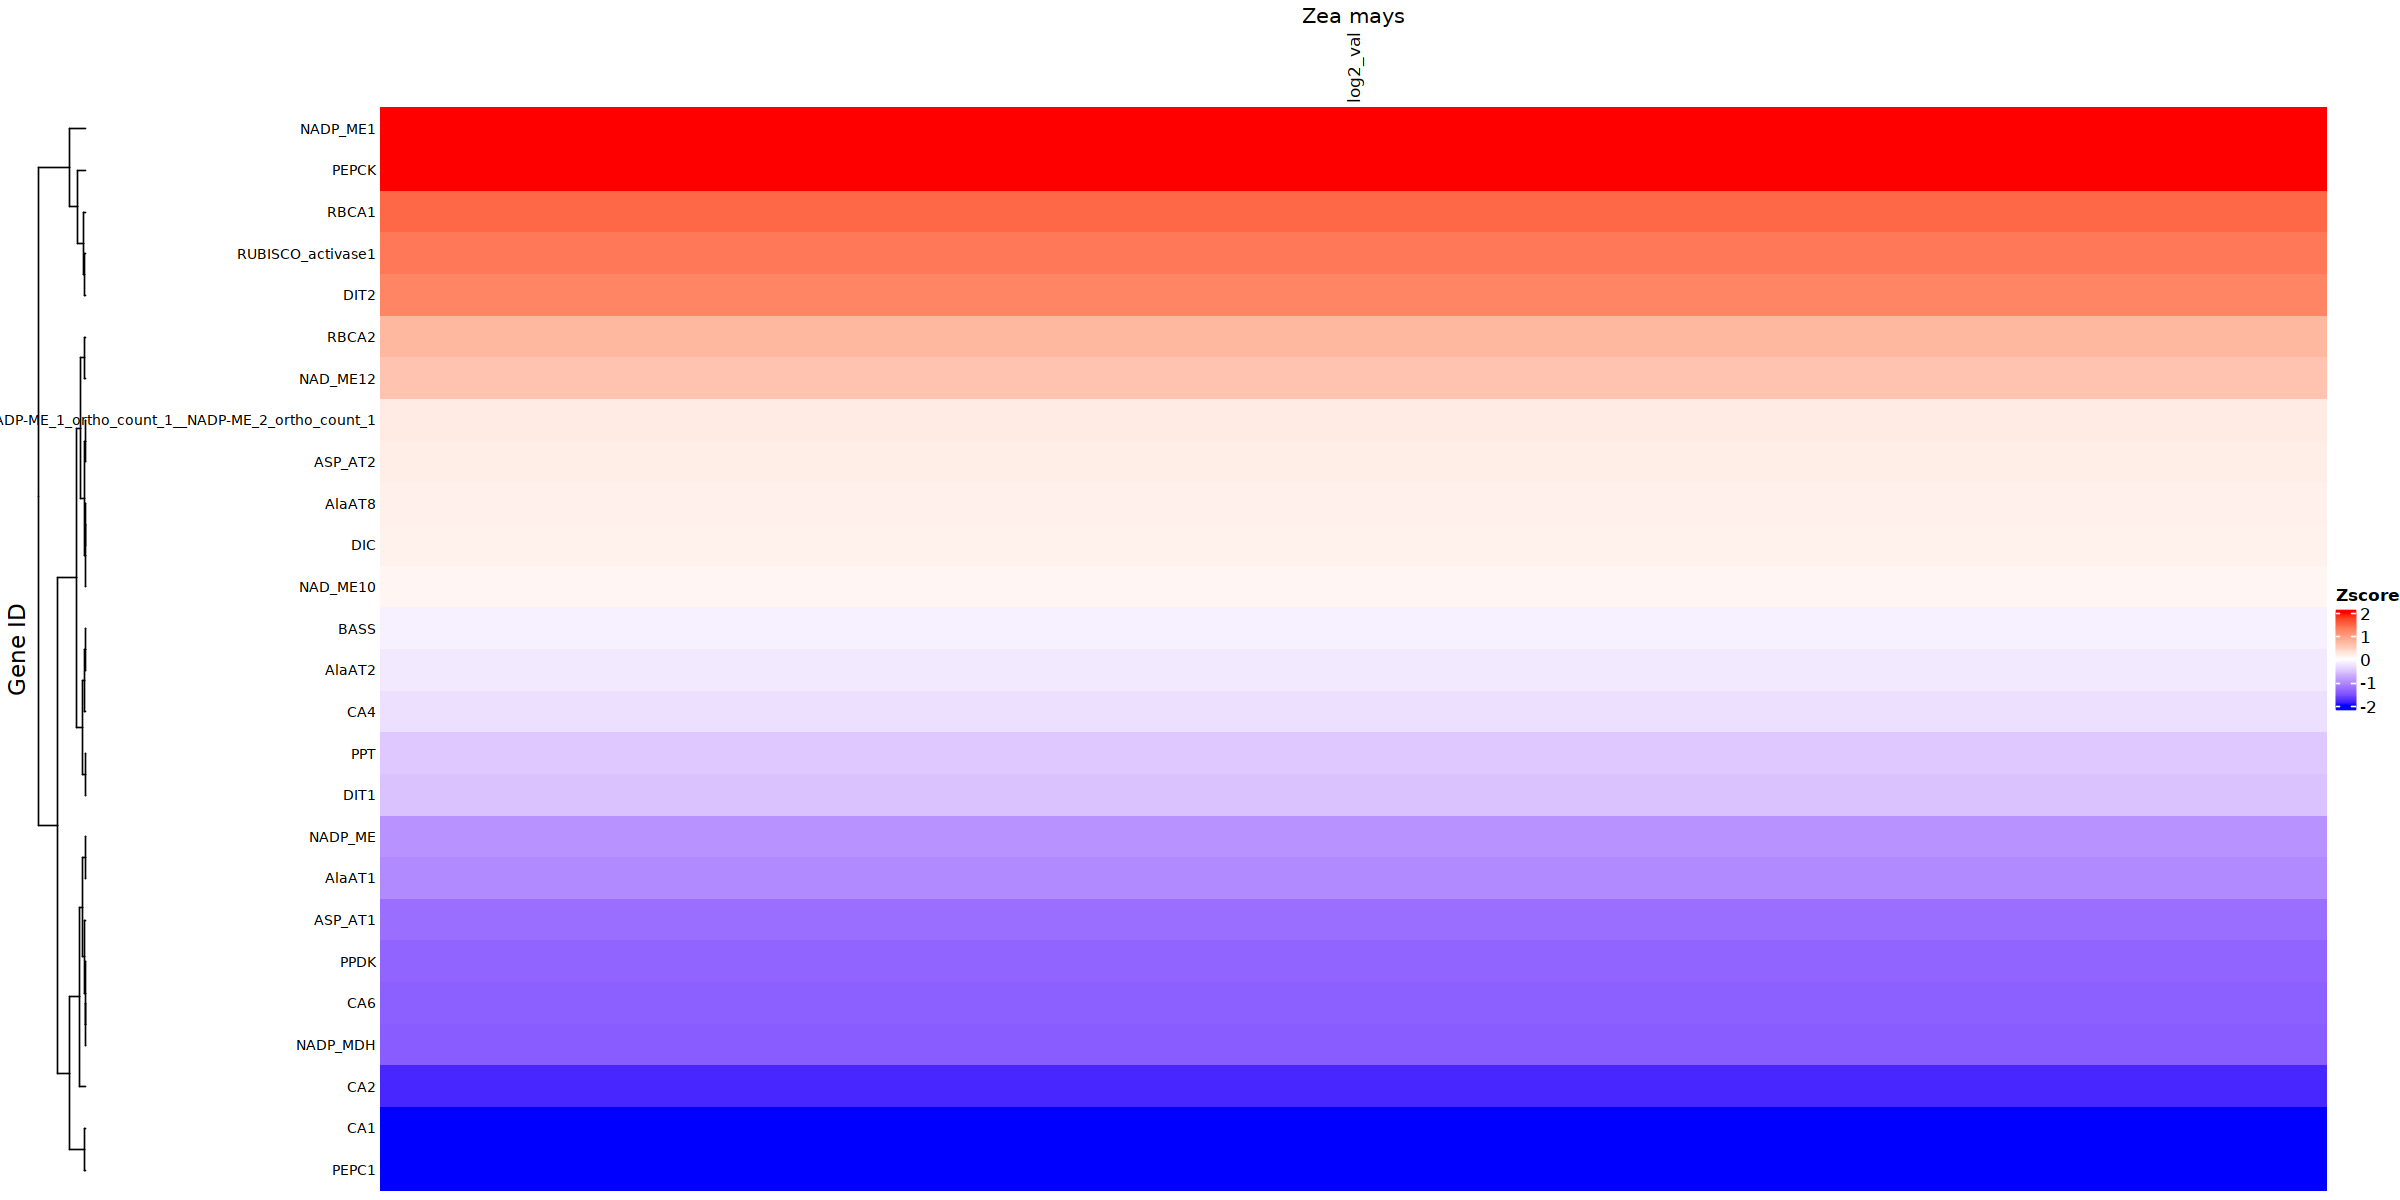

In [30]:

# # Define the cell types and their order for the heatmap columns
#column_order <- c("bundle_sheath",
#                 "mesophyll")


col_fun <- colorRamp2(c(-2, 0, 2), c("blue", "white", "red"))
#@zm_gene_array <- c("NADP_ME1", "PEPCK", "RBCA1", "RUBISCO_activase1", 
 #             "RUBISCO_activase2", "DIT2", "RBCA2", "ASP_AT2", 
 #             "AlaAT8", "DIC", "BASS", "AlaAT2", "CA4", "PPT", 
 ##             "DIT1", "NADP_ME", "AlaAT1", "ASP_AT1", "PPDK", 
  #            "CA6", "NADP_MDH", "CA2", "CA3", "CA1", "PEPC1")


# Create the heatmap
zm_heatmap <- Heatmap(
  zm_df,
  name = "Zscore",
  col = col_fun,
  row_names_side = "left",
  column_names_side = "top",
#    row_order = zm_gene_array,
  row_names_gp = gpar(fontsize = 8),
  column_names_gp = gpar(fontsize = 10),
  show_column_names = TRUE,
  show_row_names = TRUE,
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  column_dend_height = unit(1, "cm"),
  column_title_gp = gpar(fontsize = 12),
  column_title = "Zea mays",
  row_title = "Gene ID"
#  column_order = column_order
)

zm_heatmap

In [ ]:
sb_gene_activity <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/sorghum_bicolor/acc_metrics_leaf_v3_clustering_strict.mesophyll/sorghum_bicolor.gene_body_acc_leaf_v3_clustering_strict.mesophyll.counts.txt"
sb_meta <- "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/Sb_annot_final/Sb.leaf_annot.V5.meta.frozen.txt"
sb_marker_genes <- read_delim("/scratch/jpm73279/comparative_single_cell/15.snakemake_marker_ID/02.visualization_annotation/Sb.orthos_from.Zm.markers.tis_leaf.visualize.txt", delim = "\t", col_names = c("chrom", "start", "stop", "geneID", "name", "type"))


In [9]:
sb_cpm_values <- get_CPM_values(sb_gene_activity, sb_meta, "final_annotation")
sb_C4_matrix <- generate_matrix_for_heatmap(sb_cpm_values, sb_marker_genes)

Rows: 35643126 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


In [10]:
sb_df <- data.frame(sb_C4_matrix, row.names = 1)

In [11]:
# Create the heatmap
col_fun <- colorRamp2(c(-2, 0, 2), c("blue", "white", "red"))

sb_gene_array <- c("NADP_ME1_ortho_count_2", "NADP_ME1_ortho_count_1", "PEPCK", 
              "RUBISCO_activase1", "DIT2_ortho_count_1", "DIT2_ortho_count_2",
              "RBCA2__RBCA1", "ASP_AT2", "AlaAT8", "DIC", "BASS", "AlaAT2",
              "CA4", "PPT", "DIT1", "NADP_ME", "AlaAT1", "ASP_AT1", "PPDK", 
              "CA6_ortho_count_1", "CA6_ortho_count_2", "NADP_MDH_ortho_count_1",
              "NADP_MDH_ortho_count_2", "CA1", "PEPC1")

sb_heatmap <- Heatmap(
  sb_df,
  name = "log2",
  col = col_fun,
  #row_order = sb_gene_array, 
  row_names_side = "left",
  column_names_side = "top",
  row_names_gp = gpar(fontsize = 8),
  column_names_gp = gpar(fontsize = 10),
  show_column_names = TRUE,
  show_row_names = TRUE,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  column_dend_height = unit(1, "cm"),
  column_title_gp = gpar(fontsize = 12),
  column_title = "Cell Type",
  row_title = "Gene ID"
#  column_order = column_order
)

Warning message:
"The input is a data frame-like object, convert it to a matrix."


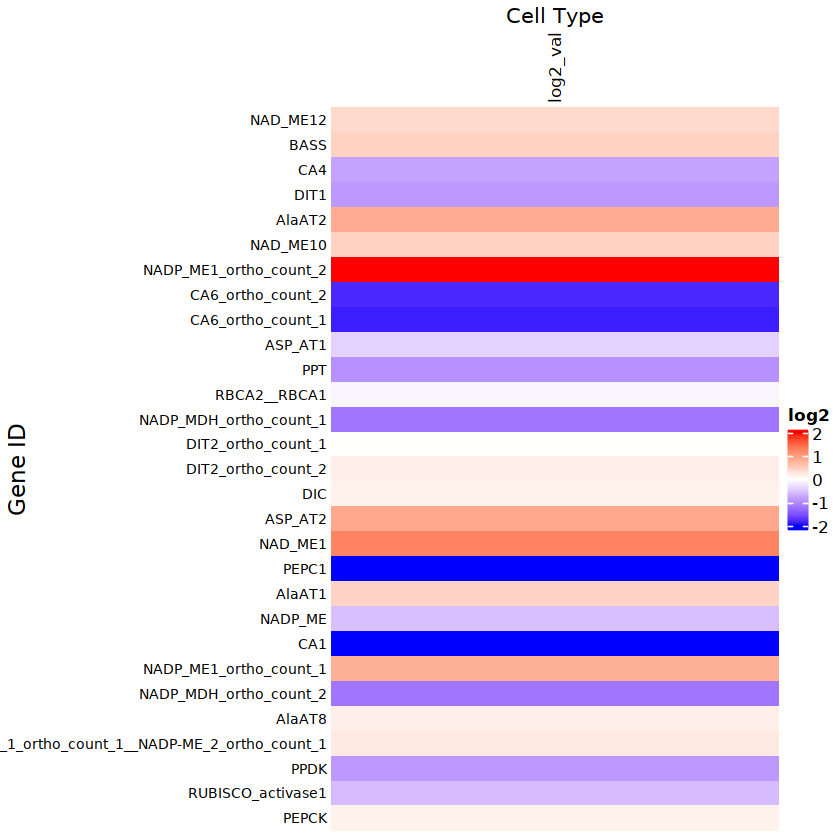

In [12]:
sb_heatmap

In [22]:
# Print the row names in the order they appear in the heatmap
#row_names_in_order = rownames(zm_df)[row_order]
#print(row_names_in_order)

# Read in Pm Genome 

In [ ]:
pm_gene_activity <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/panicum_millet/acc_metrics_leaf/panicum_millet.gene_body_acc_leaf.counts.txt"
pm_meta <- "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/pm_annot/Pm.leaf_annotation.V1.meta.txt"
pm_marker_genes <- read_delim("/home/jpm73279/genome_downloads/Pmiliaceum/markers/Pm.C4_markers.all.txt", delim = "\t", col_names = c("chrom", "start", "stop", "geneID", "name", "type"))


In [14]:
pm_cpm_values <- get_CPM_values(pm_gene_activity, pm_meta, "annotation_v1")

Rows: 54642541 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


In [15]:
pm_C4_matrix <- generate_matrix_for_heatmap(pm_cpm_values, pm_marker_genes)

Warning message in left_join(., markers, by = c("geneID")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 11 of `x` matches multiple rows in `y`.
i Row 22 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


In [16]:
pm_C4_matrix

name,log2_val
<chr>,<dbl>
PEPC_2,-3.65023576
RUBISCO_activase1_ortho_count_1,0.78678994
PPT_4,-0.80605230
NADP-MDH_3,-0.05207595
RUBISCO_activase1_ortho_count_2,0.91170813
PEP-CK_3,-0.30361472
PPA2_2,-0.32671440
AspAT_4,0.36193654
PPDK-RP,-0.58630940


In [17]:
remove_these <- c("Dit_3", "PPA3_2", "PPA3_1", "PPA2_1", "PPA1", "PPA2_2")
pm_C4_matrix.filtered <- pm_C4_matrix %>% 
    dplyr::filter(name %ni% remove_these)
pm_df <- data.frame(pm_C4_matrix.filtered, row.names = 1)

Warning message:
"The input is a data frame-like object, convert it to a matrix."


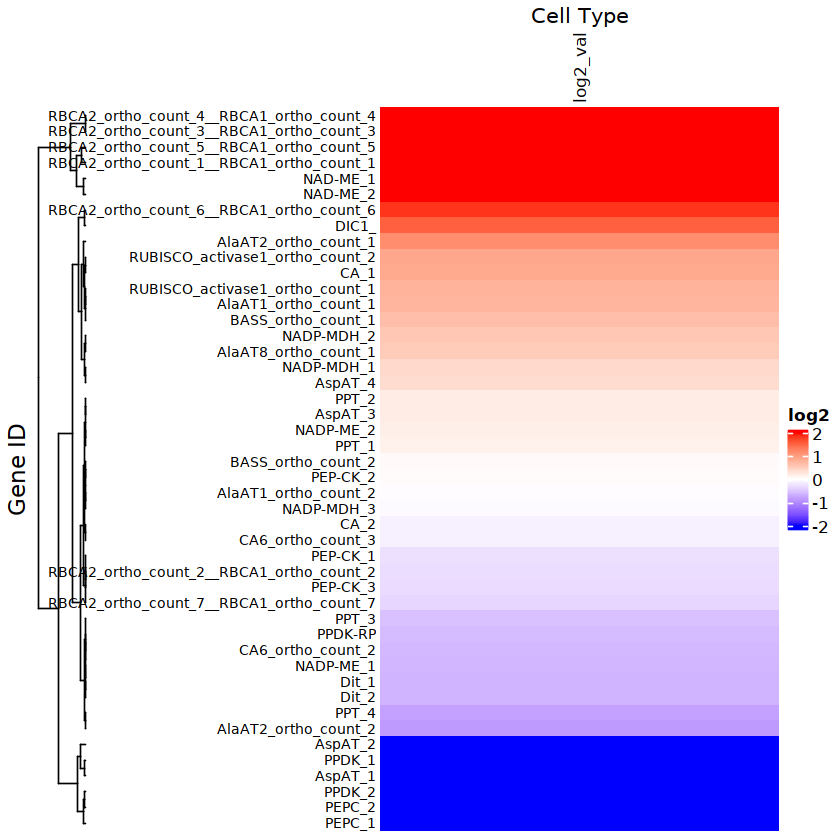

In [18]:
pm_heatmap <- Heatmap(
  pm_df,
  name = "log2",
  col = col_fun,
  #row_order = sb_gene_array, 
  row_names_side = "left",
  column_names_side = "top",
  row_names_gp = gpar(fontsize = 8),
  column_names_gp = gpar(fontsize = 10),
  show_column_names = TRUE,
  show_row_names = TRUE,
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  column_dend_height = unit(1, "cm"),
  column_title_gp = gpar(fontsize = 12),
  column_title = "Cell Type",
  row_title = "Gene ID"
#  column_order = column_order
)

pm_heatmap

In [19]:
pm_gene_array <- c(
"NAD-ME_1","NAD-ME_2",
"NADP-ME_1","NADP-ME_2","PEP-CK_1","PEP-CK_2","PEP-CK_3",
"RUBISCO_activase1_ortho_count_1","RUBISCO_activase1_ortho_count_2", "Dit_2",
"RBCA2_ortho_count_1__RBCA1_ortho_count_1","RBCA2_ortho_count_2__RBCA1_ortho_count_2",
"RBCA2_ortho_count_3__RBCA1_ortho_count_3","RBCA2_ortho_count_4__RBCA1_ortho_count_4",
"RBCA2_ortho_count_5__RBCA1_ortho_count_5","RBCA2_ortho_count_6__RBCA1_ortho_count_6",
"RBCA2_ortho_count_7__RBCA1_ortho_count_7",
"AspAT_1","AspAT_2","AspAT_3","AspAT_4","AlaAT8_ortho_count_1","DIC1_",
"BASS_ortho_count_1","BASS_ortho_count_2","AlaAT2_ortho_count_1","AlaAT2_ortho_count_2","CA_1","CA_2",
"PPT_1","PPT_2", "PPT_3","PPT_4","Dit_1",
"AlaAT1_ortho_count_1","AlaAT1_ortho_count_2","PPDK_1",
"PPDK_2","CA6_ortho_count_2","CA6_ortho_count_3",
"NADP-MDH_1","NADP-MDH_2","NADP-MDH_3",
"PPDK-RP","PEPC_1","PEPC_2")


In [20]:
remove_these <- c("Dit_3", "PPA3_2", "PPA3_1", "PPA2_1", "PPA1", "PPA2_2")

In [21]:
pm_C4_matrix.filtered %>% 
    dplyr::filter(name %ni% pm_gene_array)

pm_C4_matrix.filtered.df <- data.frame(pm_C4_matrix.filtered, row.names = 1)

name,log2_val
<chr>,<dbl>


Warning message:
"The input is a data frame-like object, convert it to a matrix."


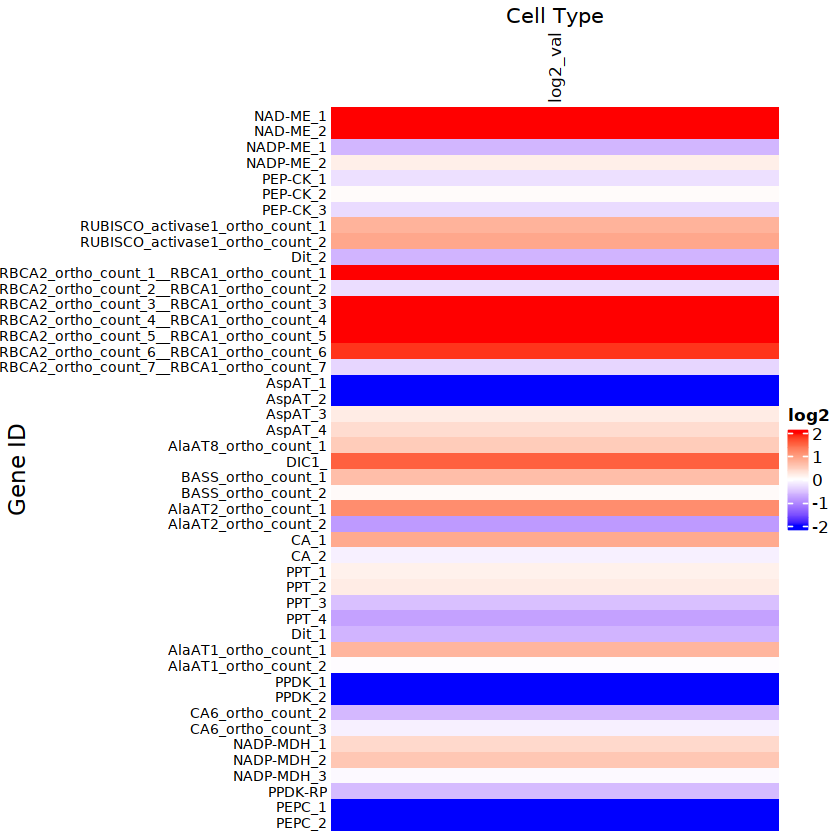

In [22]:
pm_heatmap <- Heatmap(
  pm_C4_matrix.filtered.df,
  name = "log2",
  col = col_fun,
  row_order = pm_gene_array, 
  row_names_side = "left",
  column_names_side = "top",
  row_names_gp = gpar(fontsize = 8),
  column_names_gp = gpar(fontsize = 10),
  show_column_names = TRUE,
  show_row_names = TRUE,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  column_dend_height = unit(1, "cm"),
  column_title_gp = gpar(fontsize = 12),
  column_title = "Cell Type",
  row_title = "Gene ID"
#  column_order = column_order
)

pm_heatmap

# Read in UF dataset

In [ ]:
uf_gene_activity <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/urochloa_fusca/acc_metrics_leaf_clustering/urochloa_fusca.gene_body_acc_leaf_clustering.counts.txt"
uf_meta <- "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/uf_annot/uf.leaf_annotation.V1.meta.txt"
uf_marker_genes <- read_delim("/scratch/jpm73279/comparative_single_cell/15.snakemake_marker_ID/02.visualization_annotation/Uf.orthos_from.Zm.markers.tis_leaf.visualize.txt", delim = "\t", col_names = c("chrom", "start", "stop", "geneID", "name", "type"))


In [24]:
uf_cpm_values <- get_CPM_values(uf_gene_activity, uf_meta, "annotation_v1")

Rows: 73649352 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


In [25]:
uf_C4_matrix <- generate_matrix_for_heatmap(uf_cpm_values, uf_marker_genes)

In [26]:
uf_C4_matrix.df <- data.frame(uf_C4_matrix, row.names = 1)

Warning message:
"The input is a data frame-like object, convert it to a matrix."


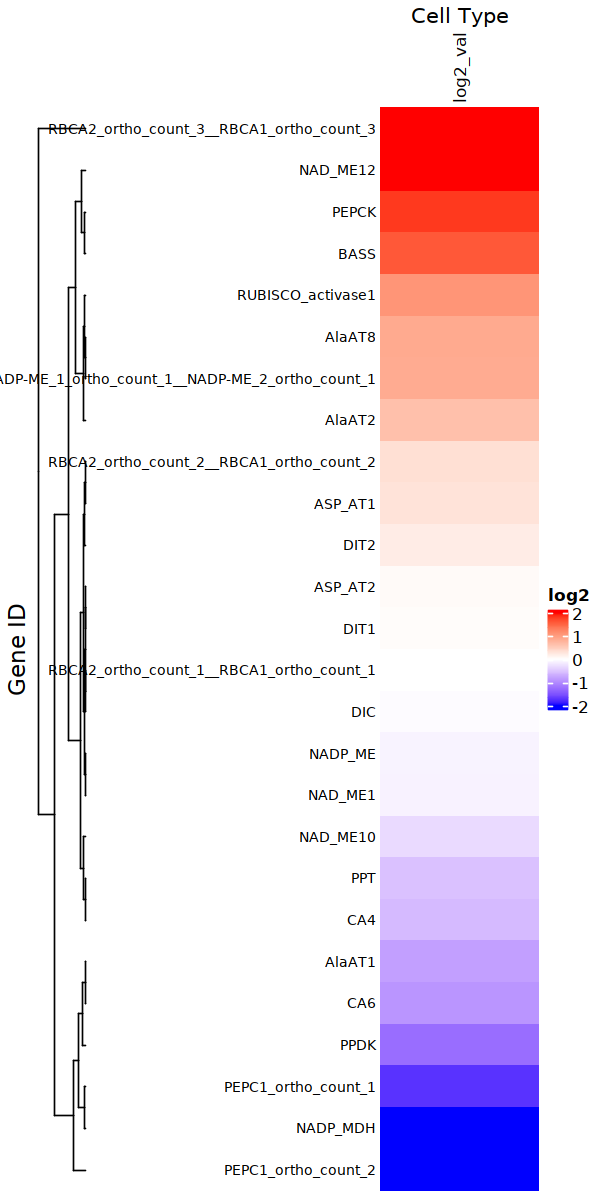

In [27]:

options(repr.plot.width=5, repr.plot.height=10)

uf_heatmap <- Heatmap(
  uf_C4_matrix.df,
  name = "log2",
  col = col_fun,
  #row_order = sb_gene_array, 
  row_names_side = "left",
  column_names_side = "top",
  row_names_gp = gpar(fontsize = 8),
  column_names_gp = gpar(fontsize = 10),
  show_column_names = TRUE,
  show_row_names = TRUE,
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  column_dend_height = unit(1, "cm"),
  column_title_gp = gpar(fontsize = 12),
  column_title = "Cell Type",
  row_title = "Gene ID"
#  column_order = column_order
)

uf_heatmap

In [29]:
zm_heatmap

ERROR: Error in eval(expr, envir, enclos): object 'zm_heatmap' not found


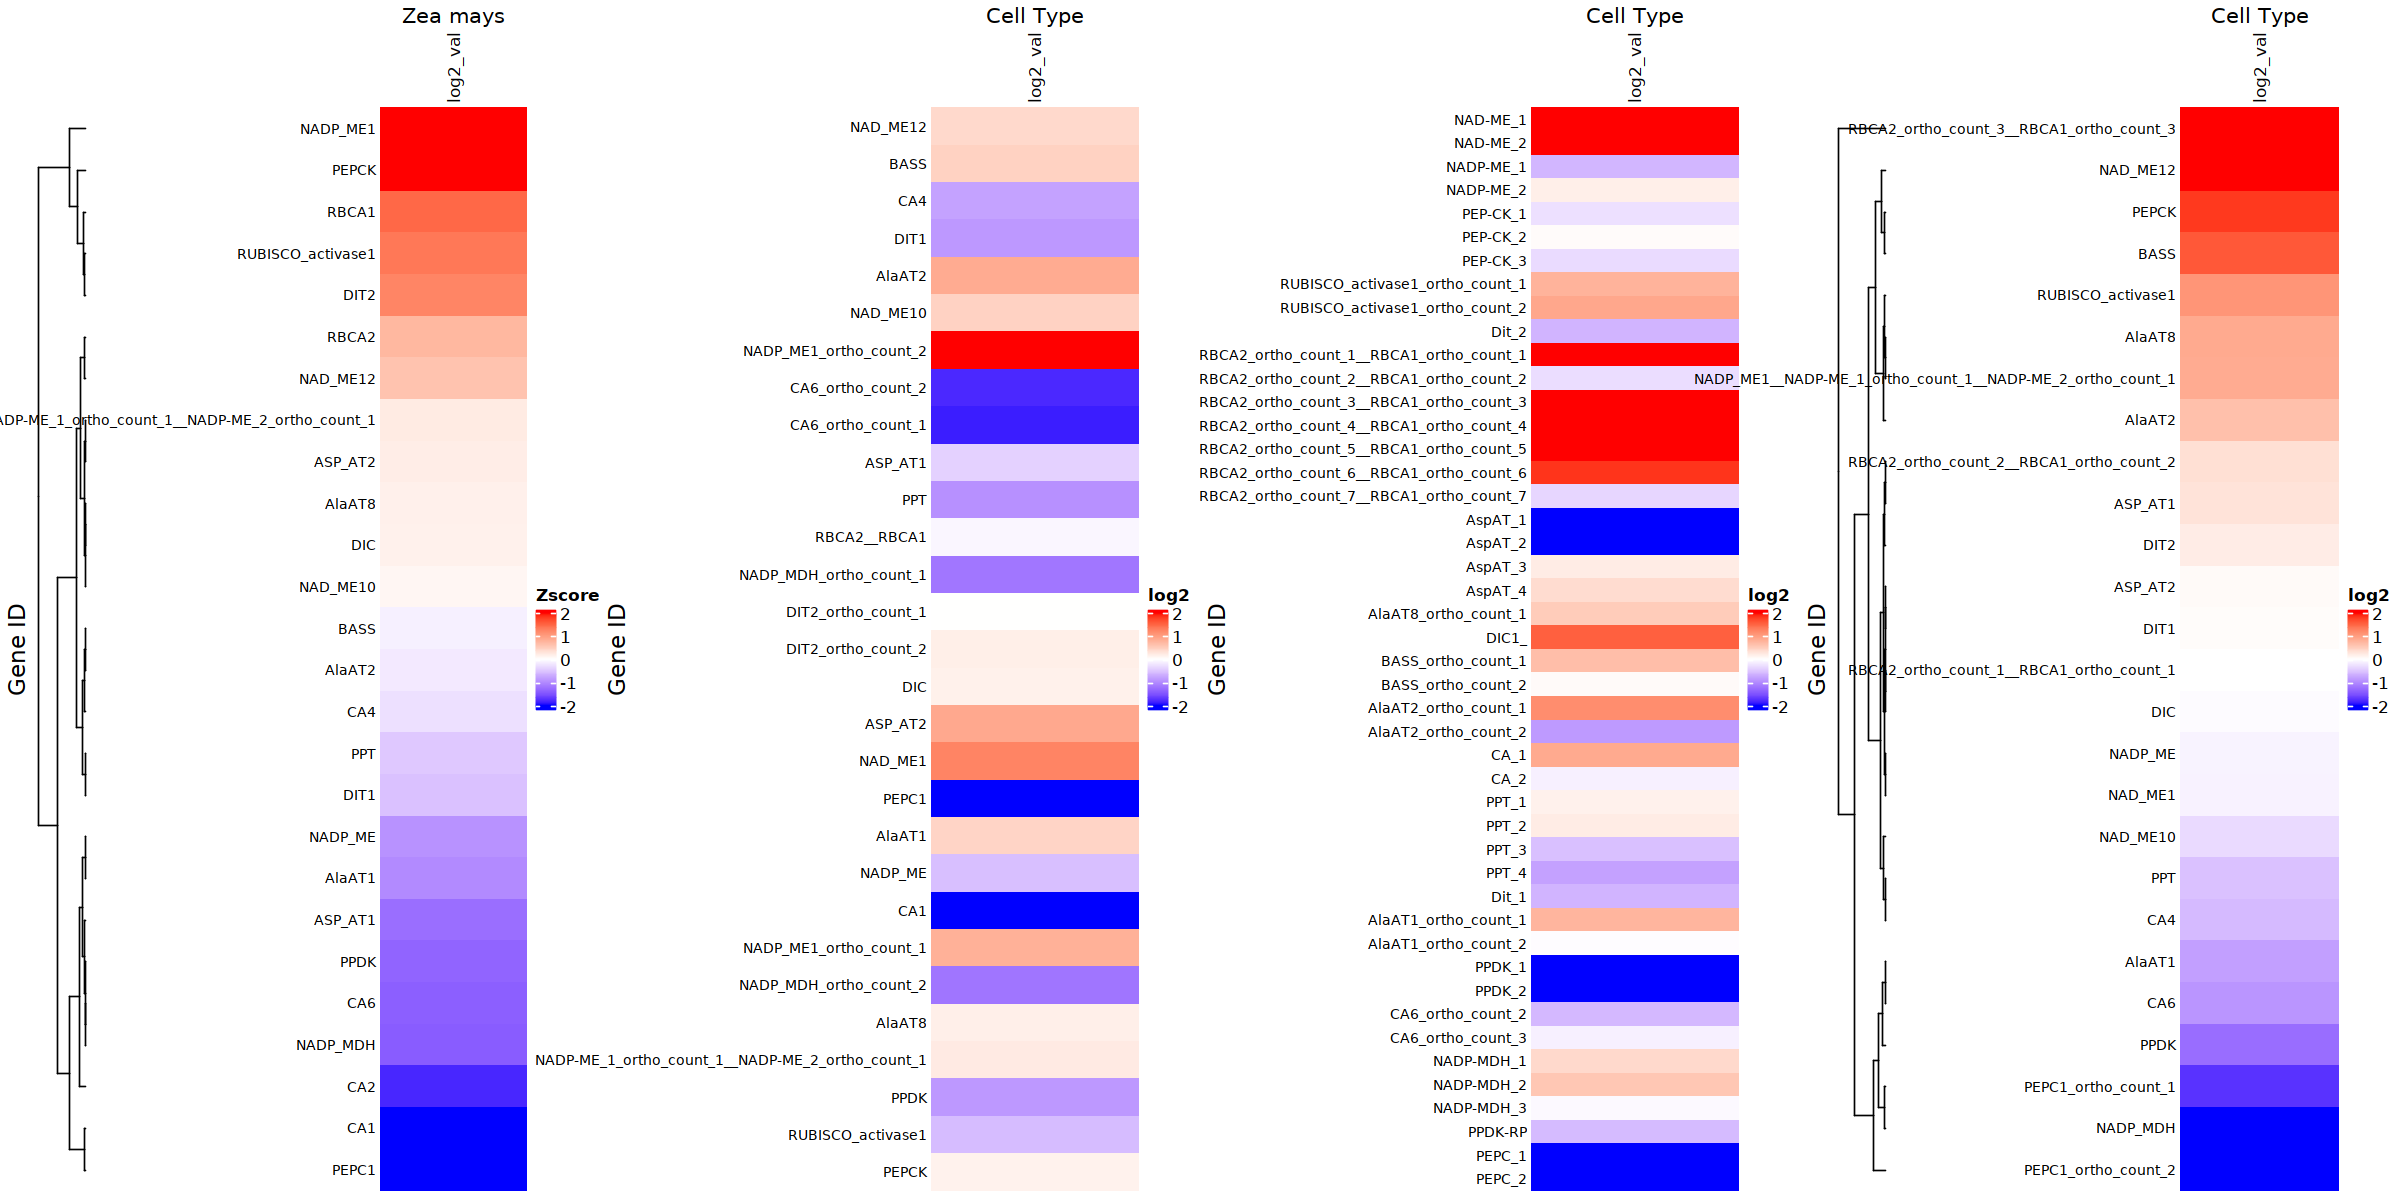

In [31]:
library(gridExtra)

options(repr.plot.width=20, repr.plot.height=10)

g1 <- grid::grid.grabExpr(draw(zm_heatmap))
g2 <- grid::grid.grabExpr(draw(sb_heatmap))
g3 <- grid::grid.grabExpr(draw(pm_heatmap))
g4 <- grid::grid.grabExpr(draw(uf_heatmap))
gridExtra::grid.arrange(g1, g2, g3, g4,nrow = 1)

In [32]:
os_gene_activity <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/oryza_sativa/acc_metrics_leaf_clusering/oryza_sativa.gene_body_acc_leaf_clusering.counts.txt"
os_meta <- "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/os_annot/os.leaf_annotation.V1.meta.txt"

In [33]:
os_marker_genes <- read_delim("/home/jpm73279/genome_downloads/Osativa/v7.0/Rice_markers/Os.leaf_markers_from_haidong.markers_from_pm.visualize.C4_markers_maize.txt", delim = "\t", col_names = c("chrom", "start", "stop", "geneID", "name", "type"))

Rows: 258 Columns: 6
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (6): chrom, start, stop, geneID, name, type

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
os_cpm_values <- get_CPM_values(os_gene_activity, os_meta, "annotation_v1")

In [ ]:
os_C4_matrix <- generate_matrix_for_heatmap(os_cpm_values, os_marker_genes)

os_C4_matrix.df <- data.frame(os_C4_matrix, row.names = 1)

# Generate Heatmap for Stuff that Doesn't Change...

In [ ]:
# Function definition
filter_tribble_by_name <- function(data, names) {
  updated <- data %>%
    filter(name %in% names)
    
    updated <- data.frame(updated, row.names = 1)
    return(updated)
}


# Generate Core C4 Gene Heatmaps

In [ ]:
col_fun <- colorRamp2(c(-2, 0, 2), c("red", "white", "blue"))


generate_split_heatmap <- function(log2matrix, df_marker_type) {
    
     updated <- log2matrix %>%
        filter(name %in% df_marker_type$name) %>% 
        left_join(.,df_marker_type, by = c("name")) %>% 
        dplyr::group_by(cell_type) %>% 
        dplyr::arrange(desc(log2_val)) %>% 
        mutate(name = str_replace_all(name, "_ortho_count_", "_"))


    return(updated)
    
}

In [ ]:
glimpse(uf_data_merged)

In [ ]:
uf_annot_markers <- c("PEPCK" = "Bundle sheath",
              "RBCA2_ortho_count_1__RBCA1_ortho_count_1" = "Bundle sheath",
              "RBCA2_ortho_count_2__RBCA1_ortho_count_2" = "Bundle sheath",
              "RBCA2_ortho_count_3__RBCA1_ortho_count_3" = "Bundle sheath",
              "RUBISCO_activase1" = "Bundle sheath",
              "DIC" = "Bundle sheath",
              "PPT" = "Mesophyll",
              "PPDK" = "Mesophyll",
              "CA4" = "Mesophyll",
              "CA6" = "Mesophyll",
              "PEPC1_ortho_count_1" = "Mesophyll",
              "PEPC1_ortho_count_2" = "Mesophyll")

uf_marker_name_type <- data.frame(name = names(uf_annot_markers), cell_type = unname(uf_annot_markers))

uf_data_merged <- generate_split_heatmap(uf_C4_matrix, uf_marker_name_type)

uf_generate_matrix <- as.matrix(uf_data_merged[,"log2_val"])
rownames(uf_generate_matrix) <- uf_data_merged$name

# create heatmap
uf_heatmap <- Heatmap(uf_generate_matrix, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = uf_data_merged$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                   #row_title = "Gene",
                   row_title = NULL,
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4", "#E31A1C")),
                        labels = unique(uf_data_merged$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Urochloa Fusca",
                   row_title_gp = gpar(fontsize = 14))

uf_heatmap
#draw(heatmap)

In [ ]:
zm_genes <- data.frame(
  name = c('PEPCK', 'RBCA1', "RBCA2",  'RUBISCO_activase1', 'RUBISCO_activase2', 
         'DIC', 'PPT', 'PPDK', 'CA2', 'CA3', 'CA1', 'PEPC1'),
  cell_type = c('Bundle sheath', 'Bundle sheath', 'Bundle sheath', 'Bundle sheath', 'Bundle sheath', 
                'Bundle sheath', 'Mesophyll', 'Mesophyll', 'Mesophyll', 
                'Mesophyll', 'Mesophyll', 'Mesophyll')
)


zm_data_merged <- generate_split_heatmap(zm_C4_matrix ,zm_genes)

zm_data_generate_matrix <- as.matrix(zm_data_merged[,"log2_val"])
rownames(zm_data_generate_matrix) <- zm_data_merged$name

# create heatmap
zm_heatmap <- Heatmap(zm_data_generate_matrix, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = zm_data_merged$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                   #row_title = "Gene",
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4", "#E31A1C")),
                        labels = unique(zm_data_merged$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Zea mays",
                   row_title_gp = gpar(fontsize = 14))

zm_heatmap

In [ ]:
sb_genes <- data.frame(
  name = c('PEPCK', 'RBCA2__RBCA1', 'RUBISCO_activase1', 'DIC', 'PPT', 'PPDK',
         'CA6_ortho_count_1', 'CA6_ortho_count_2', 'CA1', 'PEPC1'),
  cell_type = c('Bundle sheath', 'Bundle sheath', 'Bundle sheath', 'Bundle sheath',
                'Mesophyll', 'Mesophyll', 'Mesophyll', 'Mesophyll', 
                'Mesophyll', 'Mesophyll')
)

# print


sb_data_merged <- generate_split_heatmap(sb_C4_matrix ,sb_genes)
sb_data_merged


sb_data_merged <- generate_split_heatmap(sb_C4_matrix ,sb_genes)

sb_data_generate_matrix <- as.matrix(sb_data_merged[,"log2_val"])
rownames(sb_data_generate_matrix) <- sb_data_merged$name

# create heatmap
sb_heatmap <- Heatmap(sb_data_generate_matrix, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = sb_data_merged$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                   row_title = NULL,

                   #row_title = "Gene",
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4", "#E31A1C")),
                        labels = unique(sb_data_merged$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Sorghum bicolor",
                   row_title_gp = gpar(fontsize = 14))

sb_heatmap

In [ ]:
pm_genes <- data.frame(
  name = c('PEP-CK_1', 'PEP-CK_2', 'PEP-CK_3', 'RBCA2_ortho_count_1__RBCA1_ortho_count_1', 
         'RBCA2_ortho_count_3__RBCA1_ortho_count_3',
         'RBCA2_ortho_count_4__RBCA1_ortho_count_4', 'RBCA2_ortho_count_5__RBCA1_ortho_count_5', 
         'RBCA2_ortho_count_6__RBCA1_ortho_count_6', 'RUBISCO_activase1_ortho_count_1', 
         'DIC1_', 'PPT_1', 'PPT_2', 'PPT_3', 'PPT_4', 'PPDK_1', 'PPDK_2',
         'CA6_ortho_count_1', 'CA6_ortho_count_2', 'CA_2', 'PEPC_1', 'PEPC_2'),
  cell_type = c(rep('Bundle sheath', 12), rep('Mesophyll', 12))
)
# print



pm_data_merged <- generate_split_heatmap(pm_C4_matrix ,pm_genes)

pm_data_generate_matrix <- as.matrix(pm_data_merged[,"log2_val"])
rownames(pm_data_generate_matrix) <- pm_data_merged$name

# create heatmap
pm_heatmap <- Heatmap(pm_data_generate_matrix, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = pm_data_merged$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                    row_title = NULL,

                   #row_title = "Gene",
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4", "#E31A1C")),
                        labels = unique(pm_data_merged$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Panicum milliceum",
                   row_title_gp = gpar(fontsize = 14))


In [ ]:
os_data_merged

In [ ]:
os_genes <- data.frame(
  name = c('PEPCK', 'RBCA2_ortho_count_1__RBCA1_ortho_count_1', 
         'RBCA2_ortho_count_2__RBCA1_ortho_count_2', 
         'RBCA2_ortho_count_3__RBCA1_ortho_count_3', 
          'RUBISCO_activase1', 
         'DIC1__ortho_count_2', 
         'PPDK_1',
         'CA_1__CA_2', 'PEPC',
          "PEP-CK_3"),
  cell_type = c(rep('Mesophyll', 10))
)
# print

os_data_merged <- generate_split_heatmap(os_C4_matrix ,os_genes)
os_data_merged <- os_data_merged %>%  
    dplyr::mutate(name = case_when(name == "Osppc4" ~ "PEPC",
                                   TRUE ~ name))


os_data_generate_matrix <- as.matrix(os_data_merged[,"log2_val"])
rownames(os_data_generate_matrix) <- os_data_merged$name

# create heatmap
os_heatmap <- Heatmap(os_data_generate_matrix, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = os_data_merged$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                    row_title = NULL,

                   #row_title = "Gene",
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#E31A1C")),
                        labels = unique(os_data_merged$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Oryza sativa",
                   row_title_gp = gpar(fontsize = 14))


os_heatmap

In [ ]:
library(gridExtra)

options(repr.plot.width=20, repr.plot.height=10)

g1 <- grid::grid.grabExpr(draw(zm_heatmap))
g2 <- grid::grid.grabExpr(draw(sb_heatmap))
g3 <- grid::grid.grabExpr(draw(pm_heatmap))
g4 <- grid::grid.grabExpr(draw(uf_heatmap))
g5 <- grid::grid.grabExpr(draw(os_heatmap))
gridExtra::grid.arrange(g1, g2, g3, g4, g5,nrow = 1)

# Generate the Heatmaps for Differing Enzymes used in C4 Sub-Types

In [53]:
zm_markers

chrom,start,stop,geneID,name,type,X7,X8
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,227883601,227891700,Zm00001eb043270,BASS,bundle_sheath,BASS,bass1
chr2,147040782,147041974,Zm00001eb092540,RBCA2,bundle_sheath,RBCA2,ssu2
chr4,196177320,196178190,Zm00001eb197410,RBCA1,bundle_sheath,RBCA1,ssu1
chr1,207808564,207812703,Zm00001eb038930,NADP_MDH,mesophyll,NADP_MDH,mdh6
chr1,35692130,35696538,Zm00001eb011080,PEPCK,bundle_sheath,PEPCK,pck1
chr3,7184482,7190135,Zm00001eb121470,NADP_ME1,bundle_sheath,NADP_ME1,me3
chr5,222310139,222315127,Zm00001eb257910,ASP_AT1,"mesophyll,bundle_sheath",ASP_AT1,aspat1
chr8,103379473,103383953,Zm00001eb348660,ASP_AT2,"mesophyll,bundle_sheath",ASP_AT2,asp-at2
chr4,1225604,1227957,Zm00001eb164390,RUBISCO_activase1,bundle_sheath,RUBISCO+activase1,rca1


In [ ]:

#zm_genes_subtypes <- data.frame(
#  name = c("NADP_ME1", "NAD_ME10", "NAD_ME12", "NAD_ME1", "ASP_AT1", "NADP_MDH"),
#  cell_type = c("Bundle Sheath", "Mesophyll,Bundle Sheath", "Mesophyll,Bundle Sheath", "Mesophyll,Bundle Sheath", "Mesophyll", "Mesophyll")
#)
zm_genes_subtypes <- data.frame(
name = c("NADP_ME1", "NADP_ME", "NAD_ME10", "NAD_ME12", "NAD_ME1", "NADP_MDH", 
         "ASP_AT2", "ASP_AT1", "AlaAT8", "AlaAT2", "AlaAT1", "BASS", "NHD1__NHD2"),
cell_type = c("Bundle Sheath", "Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll", 
              "Mesophyll", "Mesophyll", "Mesophyll", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath",
             "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath")
)


zm_genes_subtypes$cell_type <- as.factor(zm_genes_subtypes$cell_type)
zm_genes_subtypes$cell_type <- factor(zm_genes_subtypes$cell_type, levels = c("Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll"))    
zm_genes_subtypes <- zm_genes_subtypes %>% 
    arrange(cell_type)




zm_data_merged_subtypes <- generate_split_heatmap(zm_C4_matrix, zm_genes_subtypes)

zm_data_generate_matrix_subtypes <- as.matrix(zm_data_merged_subtypes[,"log2_val"])
rownames(zm_data_generate_matrix_subtypes) <- zm_data_merged_subtypes$name

# create heatmap
zm_heatmap_nadpme <- Heatmap(zm_data_generate_matrix_subtypes, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = zm_data_merged_subtypes$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                   row_title = NULL,
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4","#CAB2D6","#E31A1C")),
                        labels = unique(zm_data_merged_subtypes$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Zea mays",
                   row_title_gp = gpar(fontsize = 14))

zm_heatmap_nadpme

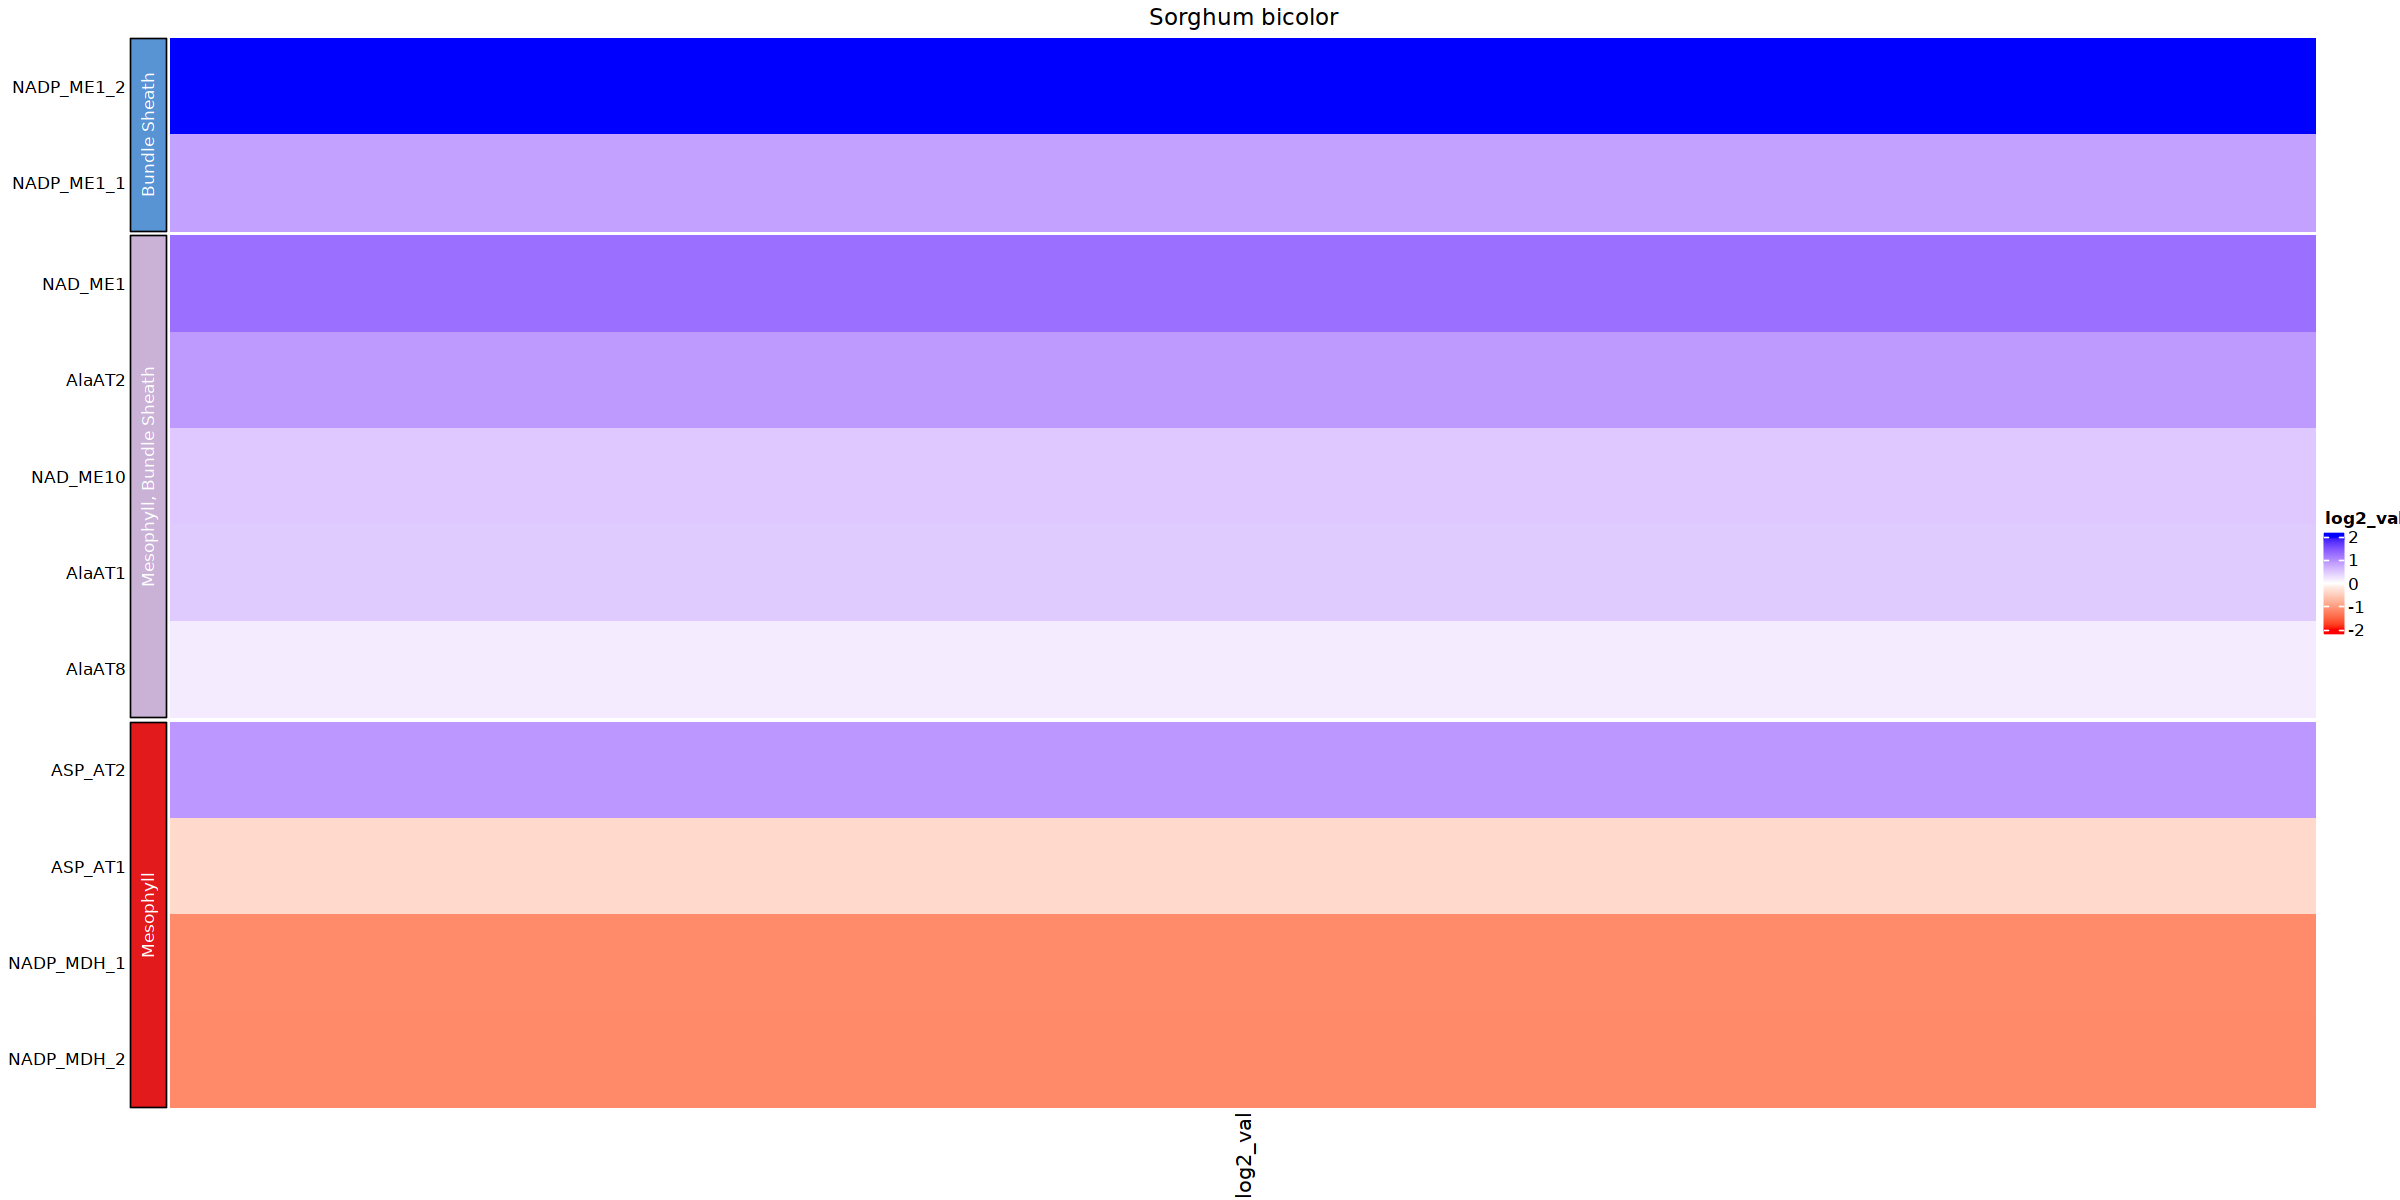

In [58]:
#sb_marker_genes_subtype <- data.frame(
#  name = c("NADP_ME1_ortho_count_1", "NADP_ME1_ortho_count_2", "NADP_MDH_ortho_count_1", "NADP_MDH_ortho_count_2", "NAD_ME1", "NAD_ME10"),
#  cell_type = c("Bundle Sheath", "Bundle Sheath", "Mesophyll", "Mesophyll", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath")
#)

sb_marker_genes_subtype <- data.frame(
name = c("NADP_ME1_ortho_count_1", "NADP_ME1_ortho_count_2", "NADP_MDH_ortho_count_1", 
         "NADP_MDH_ortho_count_2", "NAD_ME1", "NAD_ME10", "AlaAT8", 
         "AlaAT2", "AlaAT1", "ASP_AT1", "ASP_AT2",
        "BASS", "NHD1__NHD2"),
cell_type = c("Bundle Sheath", "Bundle Sheath", "Mesophyll", "Mesophyll", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", 
              "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll", "Mesophyll", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath")
)


sb_marker_genes_subtype$cell_type <- as.factor(sb_marker_genes_subtype$cell_type)
sb_marker_genes_subtype$cell_type <- factor(sb_marker_genes_subtype$cell_type, levels = c("Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll"))    
sb_marker_genes_subtype <- sb_marker_genes_subtype %>% 
    arrange(cell_type)




sb_data_merged_subtypes <- generate_split_heatmap(sb_C4_matrix, sb_marker_genes_subtype)

sb_data_generate_matrix_subtypes <- as.matrix(sb_data_merged_subtypes[,"log2_val"])
rownames(sb_data_generate_matrix_subtypes) <- sb_data_merged_subtypes$name

# create heatmap
sb_heatmap_subtypes <- Heatmap(sb_data_generate_matrix_subtypes, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = sb_data_merged_subtypes$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                   row_title = NULL,

                   #row_title = "Gene",
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4","#CAB2D6", "#E31A1C")),
                        labels = unique(sb_data_merged_subtypes$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Sorghum bicolor",
                   row_title_gp = gpar(fontsize = 14))

sb_heatmap_subtypes

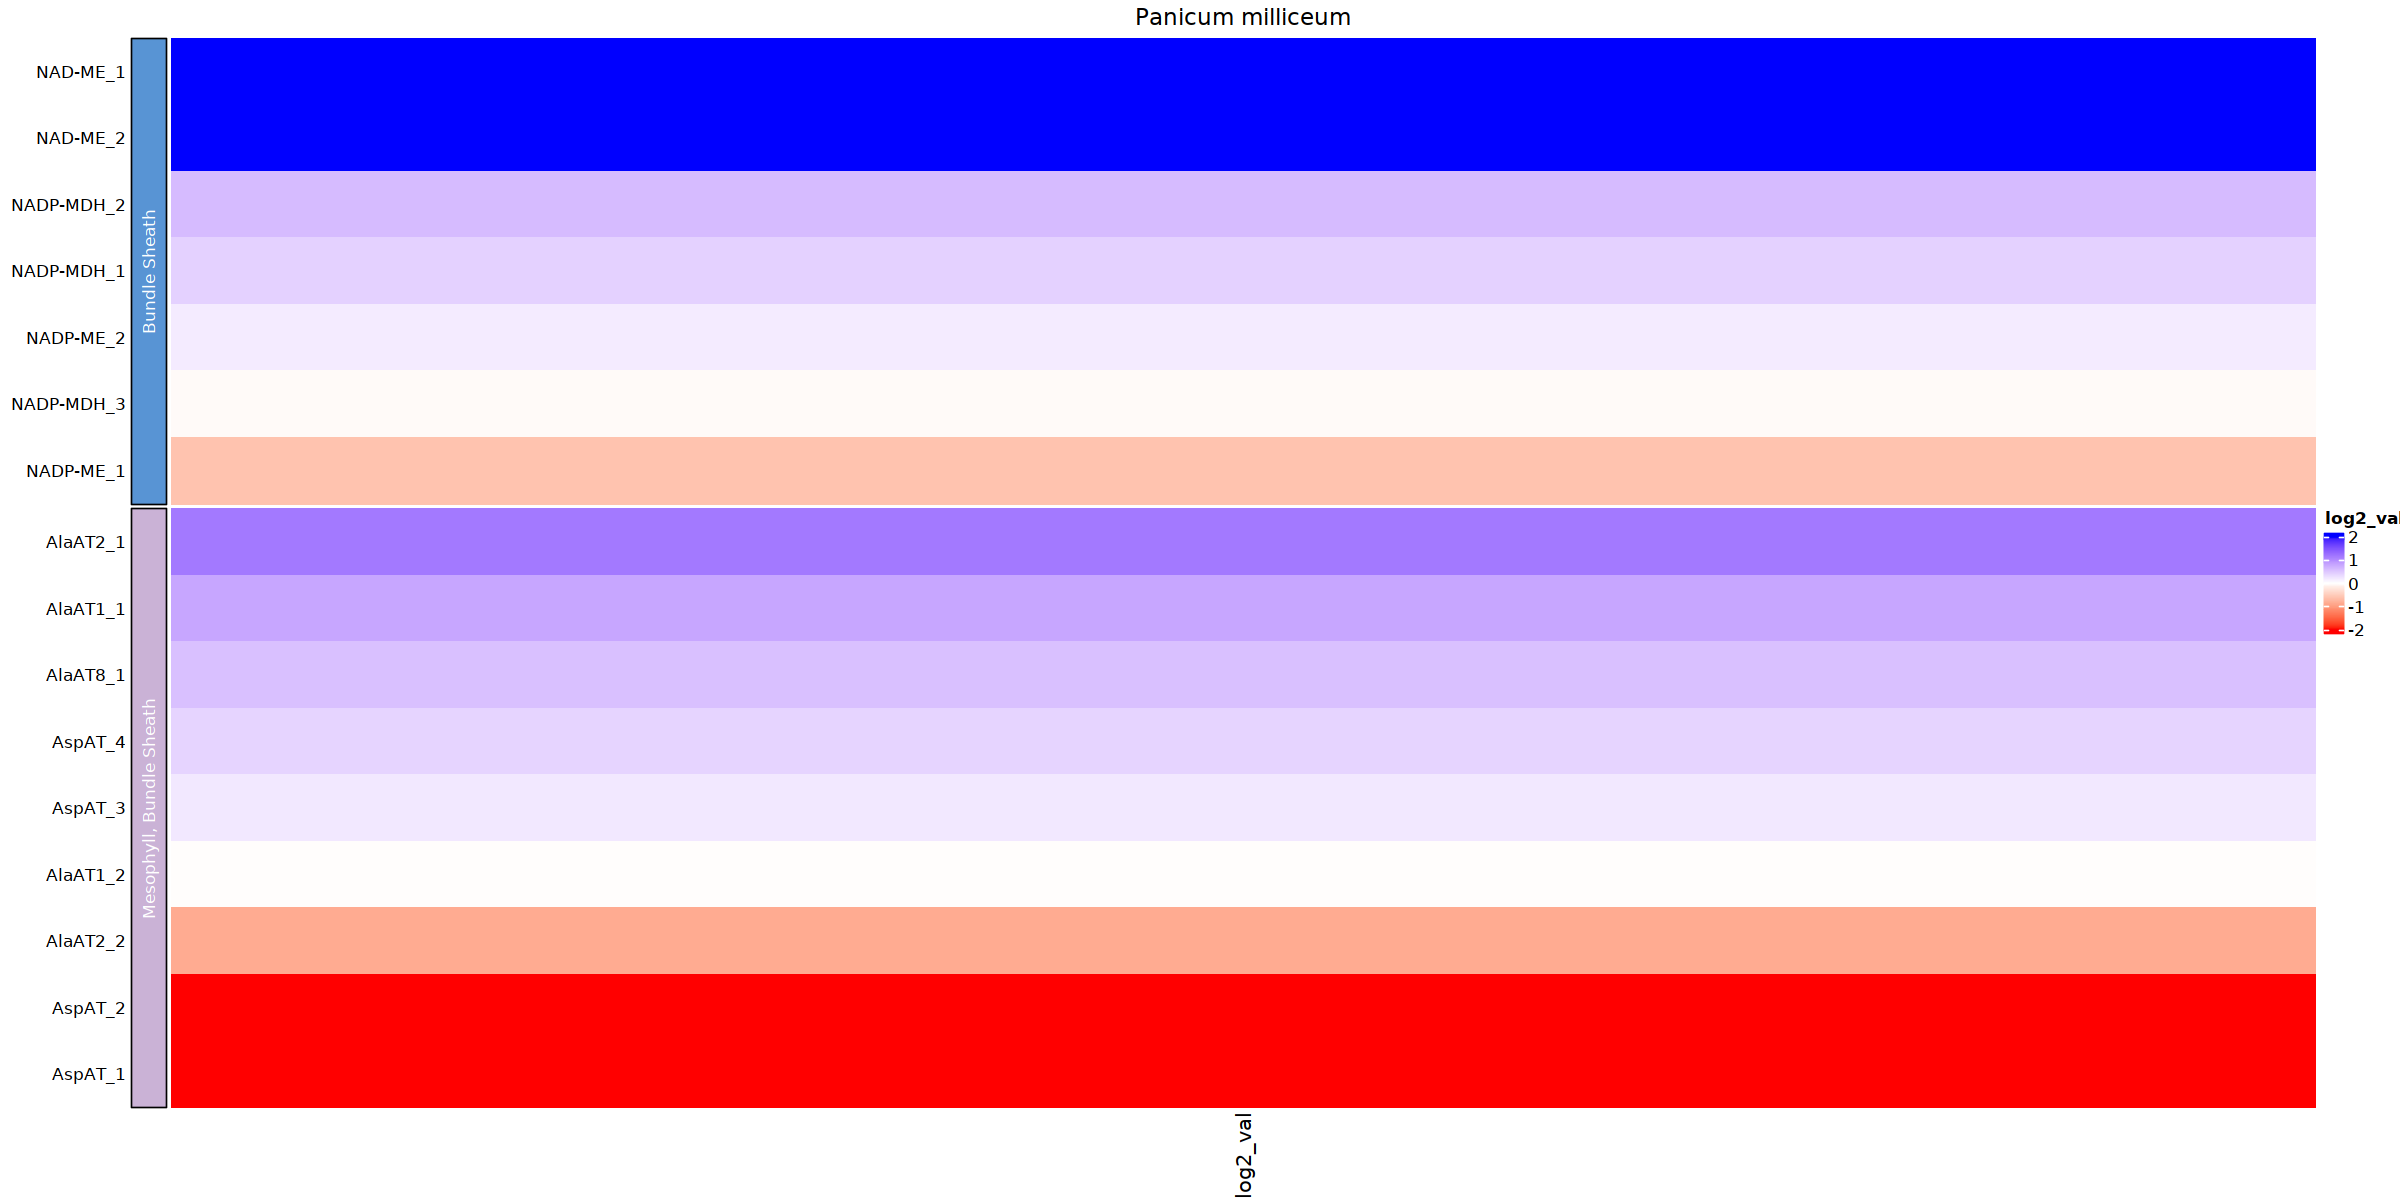

In [59]:
#pm_genes_subtype_c4 <- data.frame(
#  name = c("NADP-ME_1", "NADP-ME_2", "NAD-ME_1", "NAD-ME_2", "NADP-MDH_1", "NADP-MDH_2", "NADP-MDH_3"),
#  cell_type = c("Bundle Sheath", "Bundle Sheath", "Bundle Sheath", "Bundle Sheath", "Mesophyll", "Mesophyll", "Mesophyll")
#)

pm_genes_subtype_c4 <- data.frame(
name = c("NADP-ME_1", "NADP-ME_2", "NAD-ME_1", "NAD-ME_2", "NADP-MDH_1", 
         "NADP-MDH_2", "NADP-MDH_3", "AspAT_1", "AspAT_2", "AspAT_3", "AspAT_4", 
         "AlaAT8_ortho_count_1", "AlaAT2_ortho_count_1", 
         "AlaAT2_ortho_count_2", "AlaAT1_ortho_count_1", "AlaAT1_ortho_count_2", 
        "NHD1", "NHD2",
           "BASS_ortho_count_1", "BASS_ortho_count_2",),
cell_type = c("Bundle Sheath", "Bundle Sheath", "Bundle Sheath", "Bundle Sheath", "Bundle Sheath", 
              "Bundle Sheath", "Bundle Sheath", "Mesophyll, Bundle Sheath", 
              "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", 
              "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", 
              "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", 
              "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath",
             "Bundle Sheath","Bundle Sheath","Bundle Sheath","Bundle Sheath")
)



pm_data_merged_subtypes <- generate_split_heatmap(pm_C4_matrix, pm_genes_subtype_c4)

pm_data_generate_matrix_subtype <- as.matrix(pm_data_merged_subtypes[,"log2_val"])
rownames(pm_data_generate_matrix_subtype) <- pm_data_merged_subtypes$name

# create heatmap
pm_heatmap_subtypes <- Heatmap(pm_data_generate_matrix_subtype, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = pm_data_merged_subtypes$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                    row_title = NULL,

                   #row_title = "Gene",
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4", "#CAB2D6")),
                        labels = unique(pm_data_merged_subtypes$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Panicum milliceum",
                   row_title_gp = gpar(fontsize = 14))



pm_heatmap_subtypes

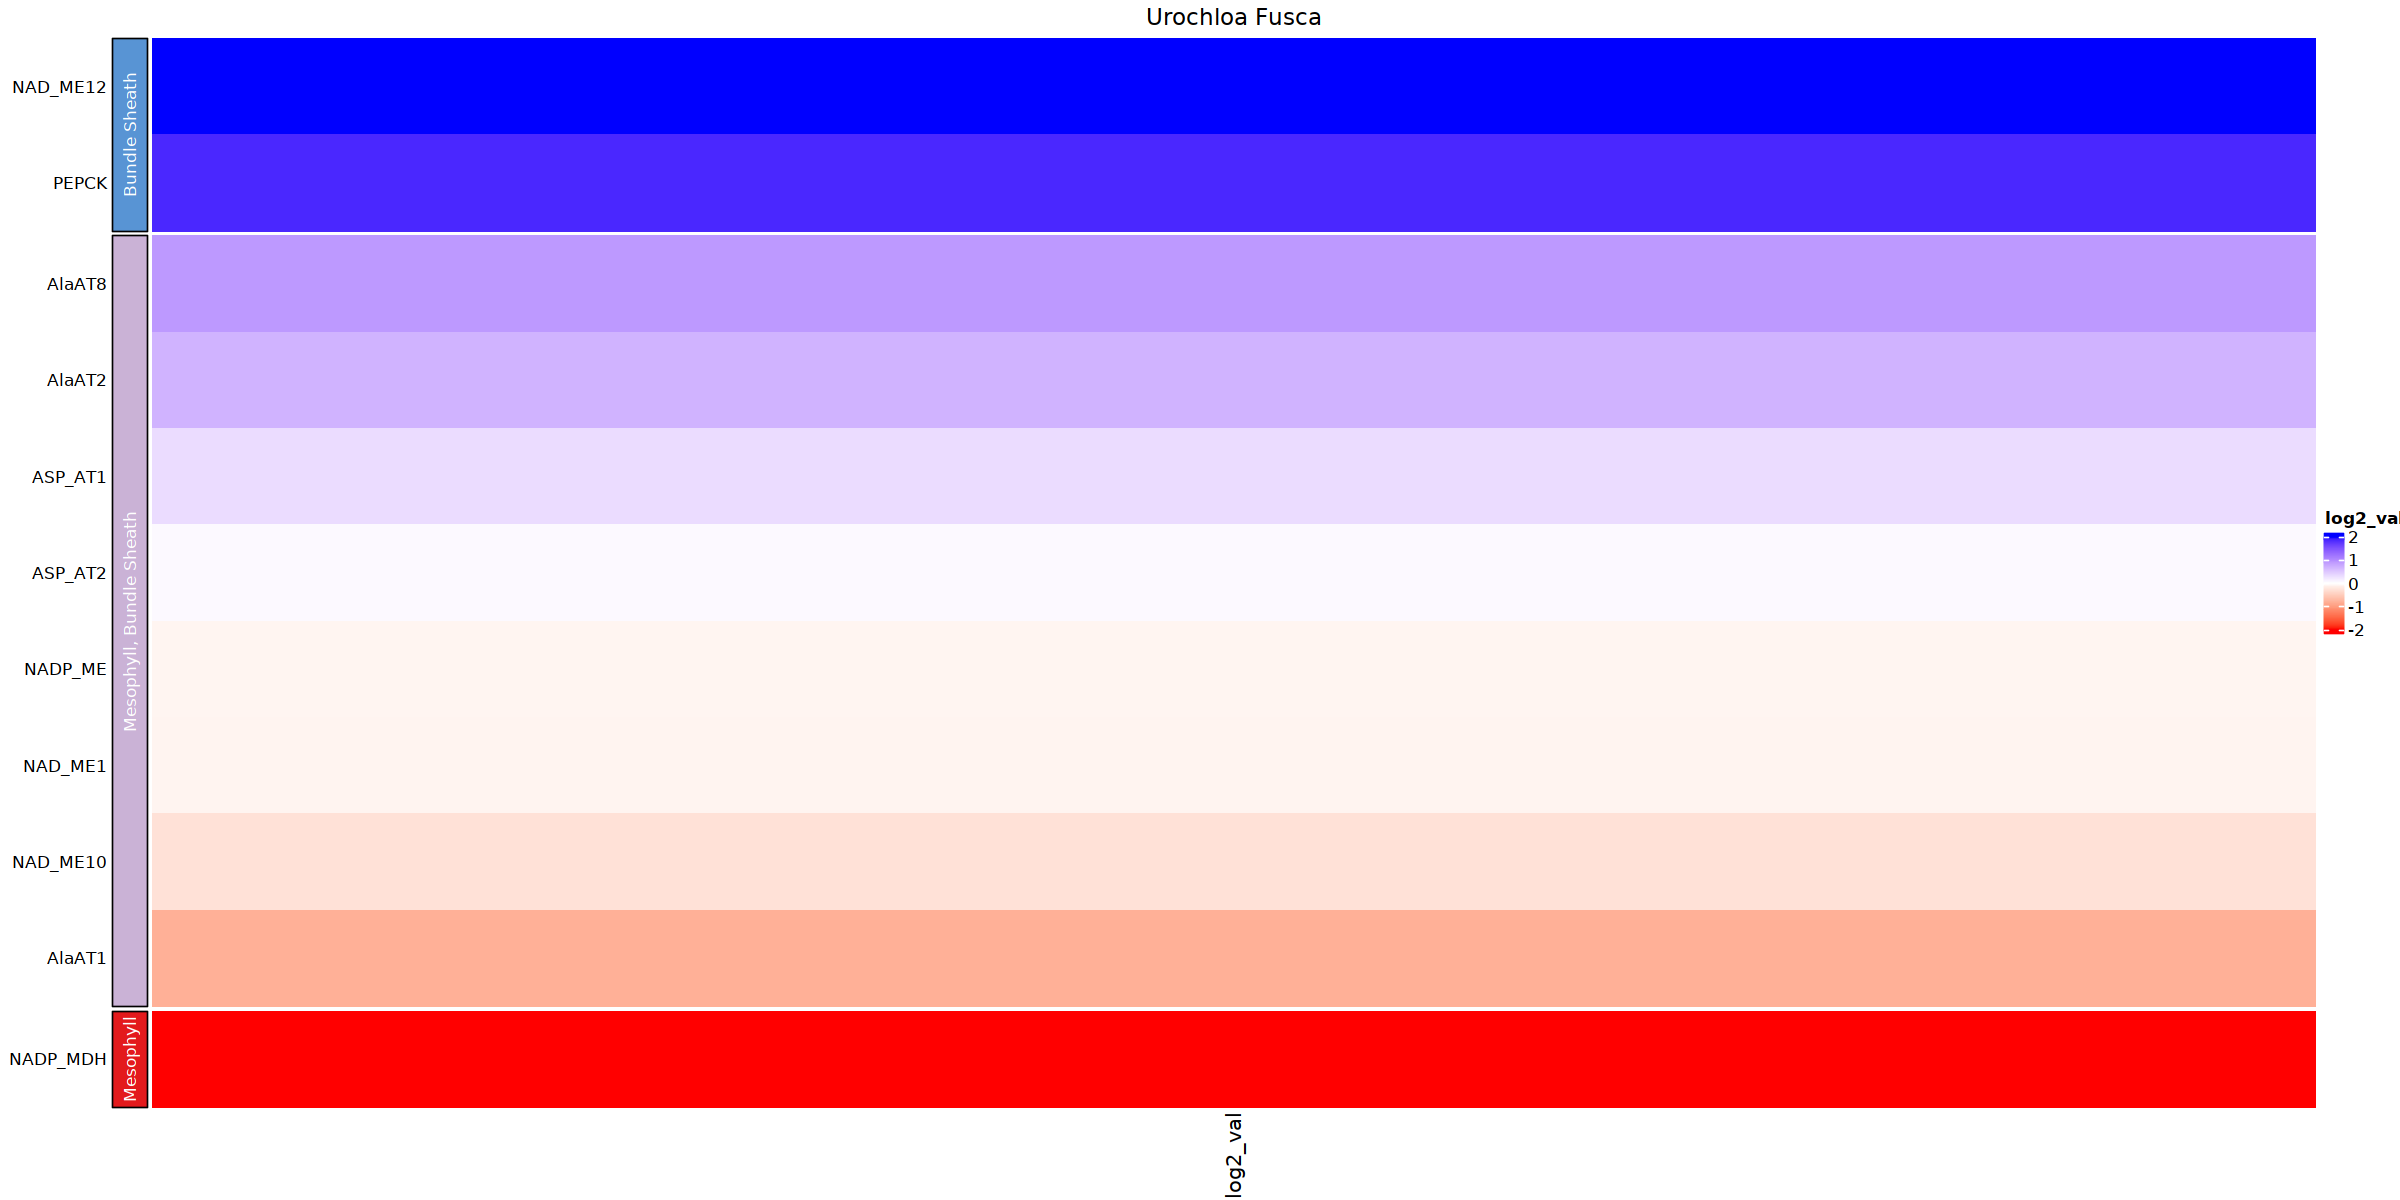

In [68]:
name <- c("NADP_MDH", "PEPCK",  
          "NADP_ME", "NAD_ME1", "NAD_ME10", "NAD_ME12", "ASP_AT1", "ASP_AT2", 
          "AlaAT1", "AlaAT2", "AlaAT8", "NHD1__NHD2", "BASS")

cell_type <- c("Mesophyll", "Bundle Sheath", "Bundle Sheath",  
               "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", 
               "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath",
               "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath","Bundle Sheath","Bundle Sheath" )

uf_annot_markers_subtype <- data.frame(name, cell_type)
 

# Create the data frame
df <- data.frame(name, cell_type)
# Assuming your data frame is named df
uf_annot_markers_subtype$cell_type <- as.factor(uf_annot_markers_subtype$cell_type)
uf_annot_markers_subtype$cell_type <- factor(uf_annot_markers_subtype$cell_type, levels = c("Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll"))    
uf_annot_markers_subtype <-  uf_annot_markers_subtype %>% 
    arrange(cell_type)


uf_data_merged_subtype <- generate_split_heatmap(uf_C4_matrix, uf_annot_markers_subtype)
uf_generate_matrix_subtype <- as.matrix(uf_data_merged_subtype[,"log2_val"])
rownames(uf_generate_matrix_subtype) <- uf_data_merged_subtype$name

# create heatmap
uf_heatmap_subtype <- Heatmap(uf_generate_matrix_subtype, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = factor(uf_annot_markers_subtype$cell_type, levels = c("Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll")),
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                   #row_title = "Gene",
                   row_title = NULL,
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4","#CAB2D6", "#E31A1C")),
                        labels = unique((uf_annot_markers_subtype$cell_type)), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Urochloa Fusca",
                   row_title_gp = gpar(fontsize = 14))

uf_heatmap_subtype
#draw(heatmap)

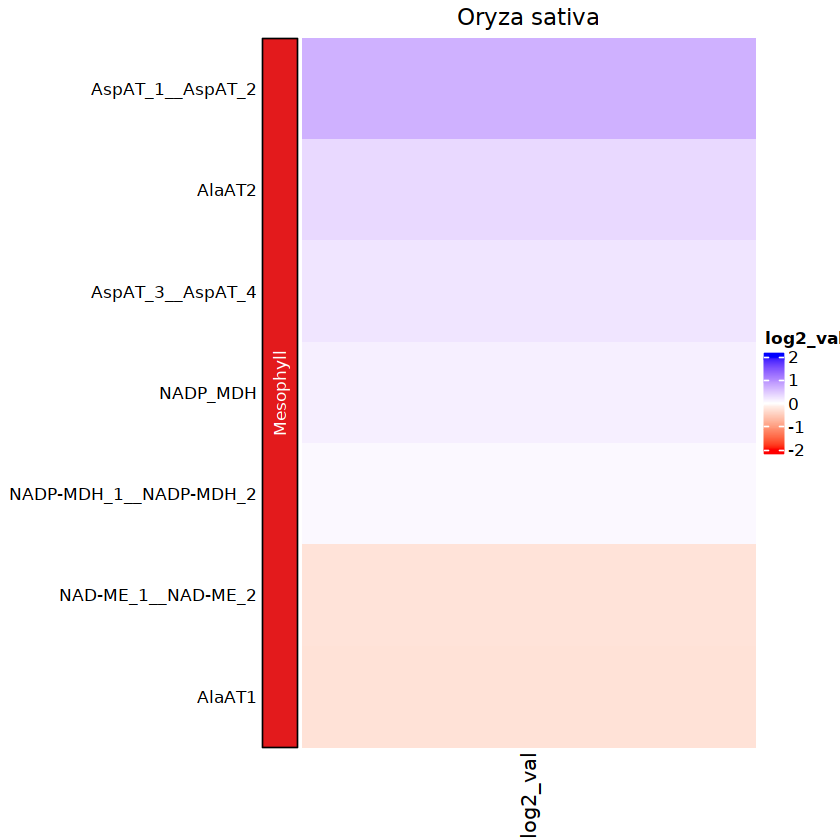

In [59]:

name = c("NAD-ME_1__NAD-ME_2", "NADP-MDH_1__NADP-MDH_2", 
         "NADP_MDH", 
         "AlaAT1", "AlaAT2", 
         "AspAT_1__AspAT_2", "AspAT_3__AspAT_4",
         "NHD1__NHD2", "BASS"
        )

cell_type <- c("Mesophyll","Mesophyll","Mesophyll","Mesophyll",
               "Mesophyll","Mesophyll", "Mesophyll", "Mesophyll, Bundle Sheath",
              "Mesophyll, Bundle Sheath")

os_annot_markers_subtype <- data.frame(name, cell_type)
 

# Create the data frame
df <- data.frame(name, cell_type)
# Assuming your data frame is named df
os_annot_markers_subtype$cell_type <- as.factor(os_annot_markers_subtype$cell_type)
os_annot_markers_subtype$cell_type <- factor(os_annot_markers_subtype$cell_type, levels = c("Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll"))    
os_annot_markers_subtype <-  os_annot_markers_subtype %>% 
    arrange(cell_type)


os_data_merged_subtype <- generate_split_heatmap(os_C4_matrix, os_annot_markers_subtype)
os_generate_matrix_subtype <- as.matrix(os_data_merged_subtype[,"log2_val"])
rownames(os_generate_matrix_subtype) <- os_data_merged_subtype$name

# create heatmap
os_heatmap_subtype <- Heatmap(os_generate_matrix_subtype, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = factor(os_annot_markers_subtype$cell_type, levels = c("Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll")),
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                   #row_title = "Gene",
                   row_title = NULL,
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#E31A1C")),
                        labels = unique((os_annot_markers_subtype$cell_type)), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Oryza sativa",
                   row_title_gp = gpar(fontsize = 14))

os_heatmap_subtype
#draw(heatmap)

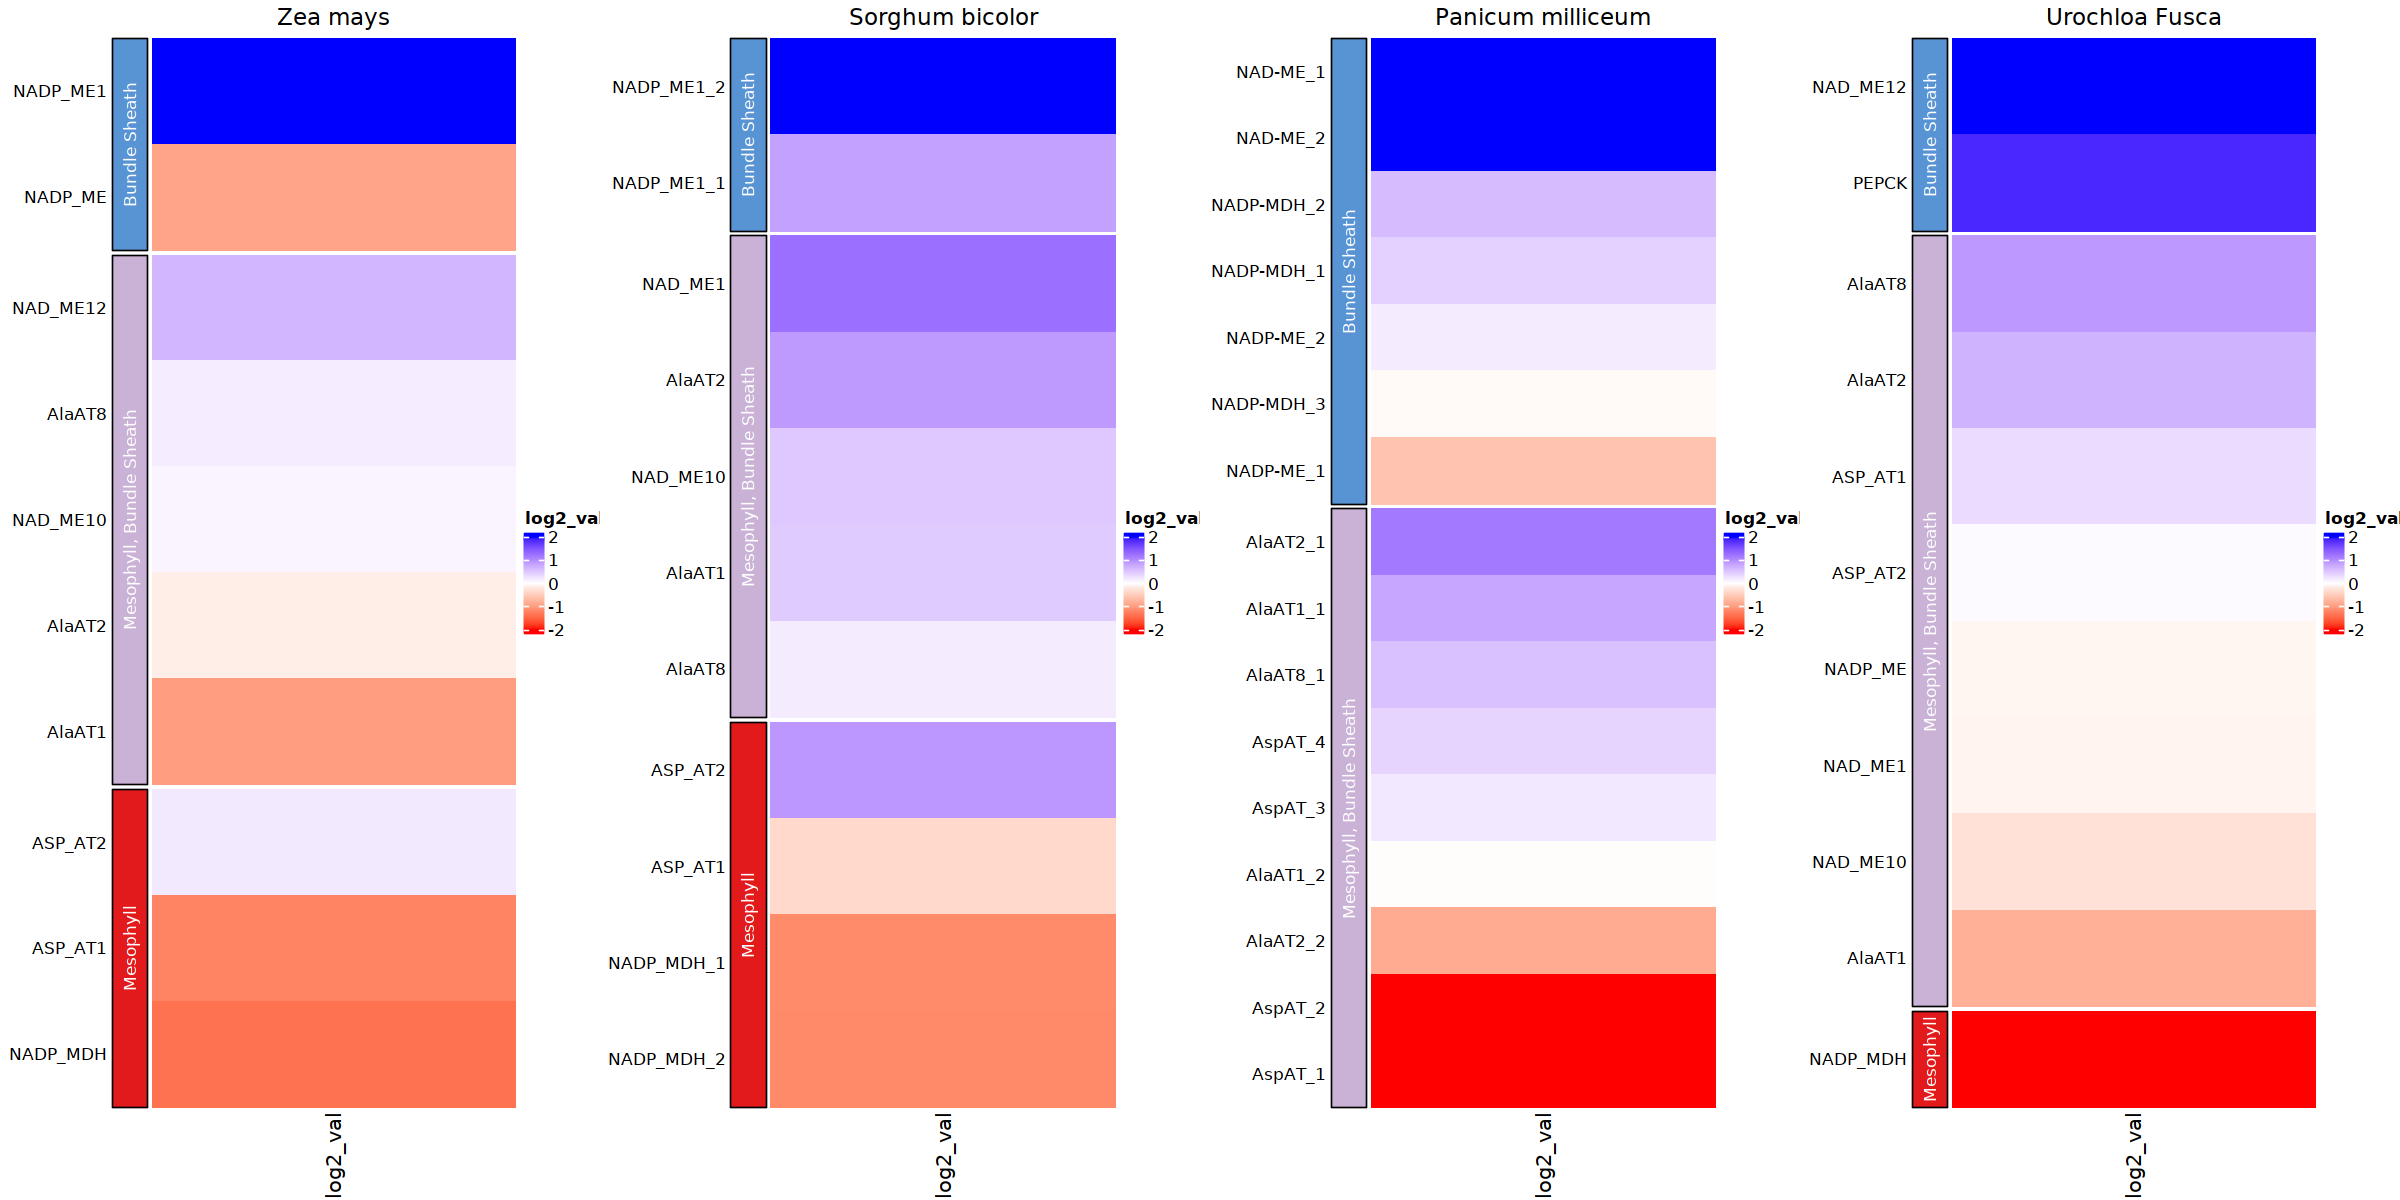

In [69]:
library(gridExtra)

options(repr.plot.width=20, repr.plot.height=10)

g1 <- grid::grid.grabExpr(draw(zm_heatmap_nadpme))
g2 <- grid::grid.grabExpr(draw(sb_heatmap_subtypes))
g3 <- grid::grid.grabExpr(draw(pm_heatmap_subtypes))
g4 <- grid::grid.grabExpr(draw(uf_heatmap_subtype))
gridExtra::grid.arrange(g1, g2, g3, g4,nrow = 1)

In [60]:
output_function <- function(output_place, heatmap, name) {
    file_name <- paste0(output_place, name)
    pdf(file = file_name, height = 6, width = 4)
    draw(heatmap)
    dev.off()
}

In [63]:
output_function(output_location, zm_heatmap, "zm_core_c4_genes.pdf")
output_function(output_location, zm_heatmap_nadpme, "zm_variable_c4_genes.pdf")

png 
  2

png 
  2

In [64]:
output_function(output_location, sb_heatmap, "sb_core_c4_genes.pdf")
output_function(output_location, sb_heatmap_subtypes, "sb_variable_c4_genes.pdf")

png 
  2

png 
  2

In [65]:
output_function(output_location, pm_heatmap, "pm_core_c4_genes.pdf")
output_function(output_location, pm_heatmap_subtypes, "pm_variable_c4_genes.pdf")

png 
  2

png 
  2

In [70]:
output_function(output_location, uf_heatmap, "uf_core_c4_genes.pdf")
output_function(output_location, uf_heatmap_subtype, "uf_variable_c4_genes.pdf")

png 
  2

png 
  2

In [61]:
output_function(output_location, os_heatmap, "os_core_c4_genes.pdf")
output_function(output_location, os_heatmap_subtype, "os_variable_c4_genes.pdf")

png 
  2

png 
  2